# Requirements

## Install packages

In [1]:
import sys

!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install mlflow
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install hyperopt

## Imports

In [2]:
import sklearn.datasets
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import mlflow
import numpy as np
import seaborn as sns
import pandas as pd
import getpass
import random
from hyperopt import hp, fmin, tpe, space_eval

## Download dataset

In [3]:
mnist = sklearn.datasets.load_digits()

In [4]:
X = mnist.data
Y = mnist.target

X_train, X_test, y_train, y_test = train_test_split(X, Y)

# Experiment tracking

## Simple example

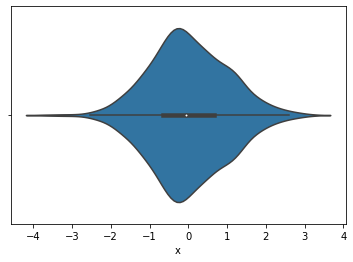

In [5]:
# Create a new experiment or use existing one
mlflow.set_experiment(experiment_name="simple_example")

# Start a ML flow experiemnt
with mlflow.start_run():
    
    # Log parameters
    mlflow.log_param("Param1", random.randint(0, 10))
    mlflow.log_param("Param2", random.randint(0, 10))
    
    # Log metrics
    mlflow.log_metric("Metric1", random.random())
    mlflow.log_metric("Metric2", random.random())
    
    # Log tag
    mlflow.set_tag("user_name", getpass.getuser())
    
    # Log artifacts
    sns_plot = sns.violinplot(x="x", data=pd.DataFrame(columns=["x"], data=np.random.randn(1000)))
    fig = sns_plot.get_figure() 
    fig.savefig("fig.png")
    mlflow.log_artifact("fig.png")

Experiment can now be accessed with `mlflow ui` command.

## Hyperparameter optimization

In [6]:
# Create a new experiment or use existing one
mlflow.set_experiment(experiment_name="hyperopt")

# Objective function
def objective(case, val):
    return val if case == 'case 1' else val**2 

# Wrap objective function to add mlflow loging
def run_objective(args):
    # Start a nested experiment
    with mlflow.start_run(nested=True) as nested_run:      
        case, val = args
        
        # Add tag
        mlflow.set_tag("objective", "dummy")
        
        # Log params
        mlflow.log_param("case", case)
        mlflow.log_param("val", val)

        metric = objective(case=case, val=val)
        
        # Log metric
        mlflow.log_metric("metric", metric)
        
        return metric
        
# Define search space
space = hp.choice('a',
    [
        ('case 1', 1 + hp.lognormal('c1', 0, 1)),
        ('case 2', hp.uniform('c2', -10, 10))
    ])
        
# Start ml flow run
with mlflow.start_run() as run:   
    best = fmin(run_objective, space, algo=tpe.suggest, max_evals=100)
    
    best_case, best_val = space_eval(space, best)
    best_metric = objective(case=best_case, val=best_val)
    
    # Log params for best run
    mlflow.log_param("case", best_case)
    mlflow.log_param("val", best_val)
    
    # Log result for best run
    mlflow.log_metric("metric", best_metric)

100%|██████████| 100/100 [00:15<00:00,  6.49it/s, best loss: 4.0711235292906046e-05]
